In [2]:
pip install --upgrade tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import UnidentifiedImageError

2025-01-28 10:11:04.897758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
feature_model = tf.keras.models.Model(inputs=base_model.input, outputs=global_avg)

In [8]:
# Function to extract features from an image
def extract_features(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))  # Resize image to 224x224
        img_array = img_to_array(img)  # Convert image to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2
        features = feature_model.predict(img_array)  # Extract features
        return features.flatten()  # Flatten the feature vector
    except (UnidentifiedImageError, ValueError, OSError) as e:
        print(f"Error loading image {image_path}: {e}")
        return None  # Return None if the image is problematic

In [ ]:
# Path to your dataset folder
dataset_folder = '/Users/dilshanperera/Desktop/New Project/ForAllProducts/images'

# Initialize lists to store features, paths, and metadata
image_features = []
image_paths = []
image_metadata = []

# Extract features and parse metadata
for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        image_path = os.path.join(dataset_folder, filename)
        
        # Parse category_id and product_id from filename (e.g., "1-45.jpg")
        try:
            category_id, product_id_with_ext = filename.split('-')
            product_id = os.path.splitext(product_id_with_ext)[0]  # Remove file extension
            features = extract_features(image_path)
            
            if features is not None:
                image_features.append(features)
                image_paths.append(image_path)
                image_metadata.append({
                    "product_id": product_id,
                    "category_id": category_id,
                    "image_path": image_path
                })
        except ValueError:
            print(f"Skipping file {filename} due to naming convention mismatch.")

# Convert metadata to a DataFrame for easy manipulation
if image_metadata:
    metadata_df = pd.DataFrame(image_metadata)
    print("Image metadata successfully extracted:")
    print(metadata_df.head())
else:
    print("No valid images were processed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━

In [11]:
# Function to find similar images
def find_similar_images(input_image_path, image_features, image_paths):
    # Extract features of the input image
    input_features = extract_features(input_image_path)
    
    # Calculate similarity between the input image and all dataset images
    similarities = cosine_similarity([input_features], image_features)
    
    # Get indices of the most similar images
    similar_images = np.argsort(similarities[0])[::-1]  # Sort in descending order of similarity
    
    return similar_images, similarities[0]


In [17]:
# Example usage: Find similar images to 'nn.jpg'
input_image_path = '/Users/dilshanperera/Desktop/New Project/ForAllProducts/input/nn.jpg'
similar_images, similarities = find_similar_images(input_image_path, image_features, image_paths)

# Display the top X most similar images
for i in range(5):
    print(f"Similar Image {i+1}: {image_paths[similar_images[i]]} (Similarity Score: {similarities[similar_images[i]]})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Similar Image 1: /Users/dilshanperera/Desktop/New Project/ForAllProducts/images/3-1337.jpg (Similarity Score: 0.664160430431366)
Similar Image 2: /Users/dilshanperera/Desktop/New Project/ForAllProducts/images/3-1336.jpg (Similarity Score: 0.6631922721862793)
Similar Image 3: /Users/dilshanperera/Desktop/New Project/ForAllProducts/images/3-1345.jpg (Similarity Score: 0.6377596855163574)
Similar Image 4: /Users/dilshanperera/Desktop/New Project/ForAllProducts/images/3-1341.jpg (Similarity Score: 0.6078692674636841)
Similar Image 5: /Users/dilshanperera/Desktop/New Project/ForAllProducts/images/3-5145.jpg (Similarity Score: 0.6002368927001953)


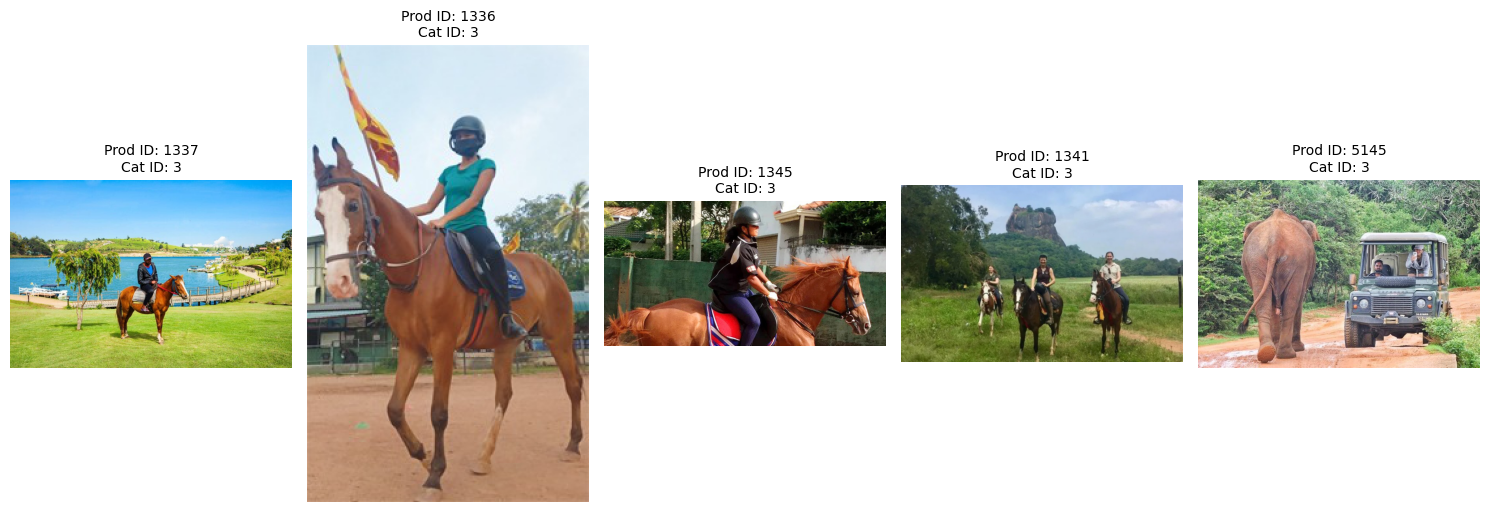

In [19]:
# Function to display similar images with metadata
def display_similar_images_with_metadata(similar_images, metadata_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        img_path = metadata_df.loc[similar_images[i], "image_path"]
        product_id = metadata_df.loc[similar_images[i], "product_id"]
        category_id = metadata_df.loc[similar_images[i], "category_id"]
        
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
        axes[i].set_title(f"Prod ID: {product_id}\nCat ID: {category_id}", fontsize=10)  # Show metadata

    plt.tight_layout()
    plt.show()

# Display the top X similar images with metadata
similar_images_indices = [image_paths.index(image_paths[i]) for i in similar_images[:5]]
display_similar_images_with_metadata(similar_images_indices, metadata_df, num_images=5)


############################################################################################################

In [21]:
import pickle

# Paths for saving pickle files
features_path = "/Users/dilshanperera/Desktop/New Project/ForAllProducts/features.pkl"
metadata_path = "/Users/dilshanperera/Desktop/New Project/ForAllProducts/metadata.pkl"
model_path = "/Users/dilshanperera/Desktop/New Project/ForAllProducts/model.pkl"

# Save extracted features and metadata
with open(features_path, "wb") as f:
    pickle.dump(image_features, f)

with open(metadata_path, "wb") as f:
    pickle.dump(image_metadata, f)

# Save the feature extraction model
with open(model_path, "wb") as f:
    pickle.dump(feature_model, f)

print("Features, metadata, and model have been saved!")


Features, metadata, and model have been saved!


In [23]:
# Load features, metadata, and model from pickle files
with open(features_path, "rb") as f:
    loaded_features = pickle.load(f)

with open(metadata_path, "rb") as f:
    loaded_metadata = pickle.load(f)

with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

print("Pickle files loaded successfully!")


Pickle files loaded successfully!


Pickle files loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step

Top 5 Similar Images:
Product ID: 180, Category ID: 3, Similarity: 1.0000
Product ID: 441, Category ID: 3, Similarity: 0.7231
Product ID: 442, Category ID: 3, Similarity: 0.7199
Product ID: 179, Category ID: 3, Similarity: 0.7147
Product ID: 443, Category ID: 3, Similarity: 0.6956


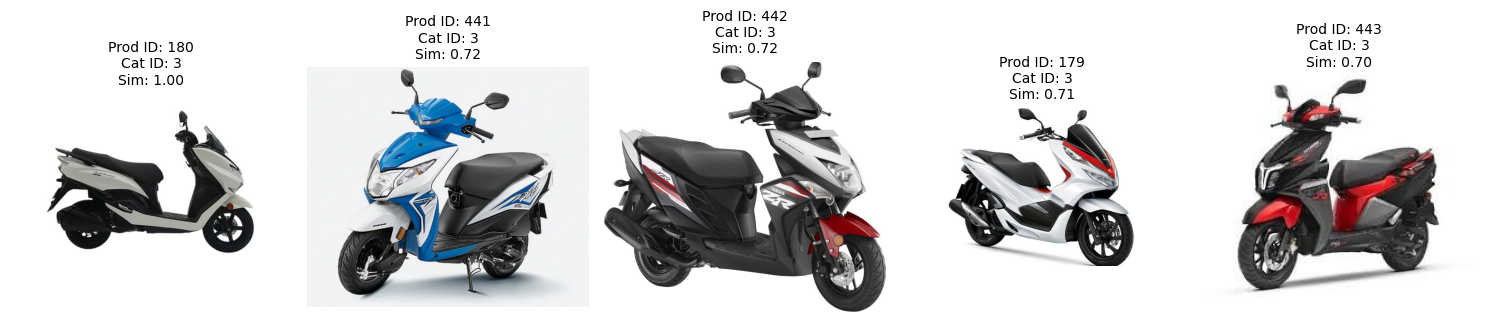

In [31]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

# Paths to pickle files
features_path = "/Users/dilshanperera/Desktop/New Project/ForAllProducts/features.pkl"
metadata_path = "/Users/dilshanperera/Desktop/New Project/ForAllProducts/metadata.pkl"
model_path = "/Users/dilshanperera/Desktop/New Project/ForAllProducts/model.pkl"

# Load the pickle files
with open(features_path, "rb") as f:
    loaded_features = pickle.load(f)

with open(metadata_path, "rb") as f:
    loaded_metadata = pickle.load(f)

with open(model_path, "rb") as f:
    feature_model = pickle.load(f)

print("Pickle files loaded successfully!")

# Convert metadata back to a DataFrame
metadata_df = pd.DataFrame(loaded_metadata)

# Function to extract features from a new image
def extract_features_from_model(image_path, model):
    try:
        img = load_img(image_path, target_size=(224, 224))  # Resize image
        img_array = img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2
        features = model.predict(img_array)  # Extract features
        return features.flatten()  # Flatten the feature vector
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# Test image path
test_image_path = '/Users/dilshanperera/Desktop/New Project/ForAllProducts/input/bi.jpg'

# Extract features for the test image
test_features = extract_features_from_model(test_image_path, feature_model)

if test_features is not None:
    # Compute similarity
    similarities = cosine_similarity([test_features], loaded_features)
    similar_images = np.argsort(similarities[0])[::-1]  # Sort by similarity

    # Display top 5 similar images with metadata
    print("\nTop 5 Similar Images:")
    for i in range(5):
        index = similar_images[i]
        product_id = metadata_df.iloc[index]['product_id']
        category_id = metadata_df.iloc[index]['category_id']
        similarity_score = similarities[0][index]
        print(f"Product ID: {product_id}, Category ID: {category_id}, Similarity: {similarity_score:.4f}")

    # Visualization
    def display_similar_images(similar_images, metadata_df, num_images=5):
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            index = similar_images[i]
            img_path = metadata_df.iloc[index]['image_path']
            product_id = metadata_df.iloc[index]['product_id']
            category_id = metadata_df.iloc[index]['category_id']
            similarity_score = similarities[0][index]

            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Prod ID: {product_id}\nCat ID: {category_id}\nSim: {similarity_score:.2f}", fontsize=10)
        plt.tight_layout()
        plt.show()

    # Display the images
    display_similar_images(similar_images, metadata_df, num_images=5)
else:
    print("Failed to extract features from the test image.")
